# Outline

- create a model that predicts the category of each article by **Self-Attention** mechanism
- train data is `matichon.json` that contains about 17K articles of Thai news by Matichon between 2015-2018
- X is `article` of news (limit first 500 tokens)
- y is category (10 labels)
- F1 score of Logistic Regression using article : **0.81**

# Import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from keras.layers import Dense, Input, Embedding, Attention, GlobalMaxPool1D, BatchNormalization, Dropout
from keras.models import Model
from keras.utils import plot_model, to_categorical, pad_sequences

from gensim.models import Word2Vec

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from cleanThaiText import tokenize

- custom tokenization function
- remove all quotations and shrink newlines `\n` and white spaces 

# Load data

- target variable is `category`
- `headline` and `article` are untokenized text

In [3]:
## load pre-trained word vector
wv_model = Word2Vec.load("data/word2vec_matichon.model")

## load matichon news data
## drop "date", "url", and "id"
df = pd.read_json('data/matichon.json')
df.drop(columns=['date','url','id'], inplace=True)

df

,headline,article,category
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment
...,...,...,...
17104,โบว์ ณัฏฐา แจ้งความ พล.ต.อ.ศรีวราห์ ถูกพาดพิง...,เมื่อวันที่ 5 ก.ค. ที่ สน.พญาไท น.ส.ณัฏฐา มหัท...,politics
17105,ภาพบรรยากาศ ขุดทางระบายน้ำ เร่งนำ 13 ชีวิตออกจ...,วันที่ 5 กรกฎาคม เจ้าหน้าที่ขุดทางระบายน้ำที่ด...,region
17106,สนช.ผ่านพ.ร.บ.สงฆ์ 3 วาระรวด พระมหากษัตริย์ทรง...,"สนช.ผ่าน พ.ร.บ.สงฆ์ 3 วาระรวด ""วิษณุ"" แจงสาระส...",politics
17107,นานาทรรศนะเพิ่มค่าปรับหมอ 5ล้านบ. สกัดเบี้ยว...,หมายเหตุ – จากกรณีที่ กระทรวงศึกษาธิการ (ศธ.) ...,education


In [4]:
## value counts of target variable
df.category.value_counts()

category
politics         3135
region           2655
crime            2141
local            1938
publicize        1481
foreign          1329
economy          1249
sport            1202
education        1053
entertainment     926
Name: count, dtype: int64

# Preprocessing

### tokenize

- it may take more than 2 minutes
- you can save the tokenized file by `df.to_json('XXX.json', orient='records')`
- limit only first 512 tokens 

In [5]:
df['tokens'] = (df['headline'] + ' ' + df['article']).apply(lambda x : tokenize(x, keep_whitespace=True))
df.head()

,headline,article,category,tokens
0,ซาอุฯจ่อเปิดไฟเขียวให้สิทธิหญิงม่าย-หย่าร้างปก...,(2 ธ.ค.58) หนังสือพิมพ์อัล ริยาดของทางการซาอุด...,foreign,"[ซาอุฯ, จ่อ, เปิดไฟเขียว, ให้, สิทธิ, หญิง, ม่..."
1,"""ไก่อู""ชี้ ตู่-เต้น ไม่ได้มีหน้าที่ตรวจสอบทุจร...","""บิ๊กป้อม"" แจง ครม. มีความพยายามยุยงปลุกปั่นให...",politics,"[ไก่อู, ชี้, ตู่, เต้น, ไม่, ได้, มี, หน้าที่,..."
2,"เปิดใจ ""โบว์ แวนดา"" ระหว่างรอยิ้มได้เต็มที่ในว...",แม้จะทำหน้าที่ภรรยาที่ดีมาเฝ้าปอ – ทฤษฎี สหวงษ...,entertainment,"[เปิดใจ, โบว์, แวนดา, ระหว่าง, รอ, ยิ้ม, ได้, ..."
3,"""นาย ณภัทร"" ปลื้มคนชมแชมป์ขึ้นปกนิตยสารแห่งปี ...",กลายเป็นดาราหนุ่มเนื้อหอมแฟนคลับแน่น กระแสมาแร...,entertainment,"[นาย, ณ, ภัทร, ปลื้ม, คน, ชม, แชมป์, ขึ้น, ปก,..."
4,"คอแทบหัก! แม่ยกแห่คล้องพวงมาลัยักษ์ ""บอย ศิริช...",แสดงดีจนเป็นที่ถูกอกถูกใจแฟนคลับ จนได้รับพวงมา...,entertainment,"[คอ, แทบ, หัก, แม่ยก, แห่, คล้อง, พวงมาลัย, ัก..."


In [6]:
df['tokens'] = df['tokens'].apply(lambda x: x[:512])

## check min, mean, max length of tokens
df['tokens'].apply(len).describe()

count    17109.000000
mean       316.643696
std        134.926703
min         26.000000
25%        209.000000
50%        302.000000
75%        439.000000
max        512.000000
Name: tokens, dtype: float64

### indexing & one-hot-encoding

- indexing(label encoding) is a process to convert categorical data into numerical form
~~~python
vocab : {'อร่อย':0, 'ไทย':1,...}
y : {'crime':0, 'economy':1,...}
~~~

- one-hot-encoding is also required for `y` to pass to a NN model

In [7]:
## make vocaburary list
all_vocabs = sorted(set.union(*df['tokens'].apply(set)))
print('total vocab in headline :', len(all_vocabs))

## indexing for vocab
vocab2index = {'<PADDING>':0} # special symbol for padding and EoS
for i, vocab in enumerate(all_vocabs):
    vocab2index[vocab] = len(vocab2index)

## label encoding for y
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(df['category'])

## one-hot-encoding
y = to_categorical(y, num_classes=len(y_encoder.classes_))

total vocab in headline : 42579


### create `X` sequence and train-test splitting

- max length = 500

In [8]:
MAX_LENGTH = 512

X = [[vocab2index[token] for token in tokens] for tokens in df['tokens']]
X = pad_sequences(X, maxlen=MAX_LENGTH, padding="post")

X

array([[ 8211,  6890, 35660, ...,     0,     0,     0],
       [41849,  7745, 10908, ...,     0,     0,     0],
       [35657, 40864, 39942, ...,  4133, 27563, 24966],
       ...,
       [26884, 17692, 17914, ..., 20476, 34713, 27179],
       [13792, 11603, 36143, ..., 39023, 17049, 42243],
       [25161, 13813, 26523, ...,     0,     0,     0]], dtype=int32)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['category'], random_state=42)

print('TRAIN:', X_train.shape, y_train.shape)
print('TEST :', X_test.shape, y_test.shape)

TRAIN: (13687, 512) (13687, 10)
TEST : (3422, 512) (3422, 10)


In [10]:
## how to inverse
y_encoder.inverse_transform(np.argmax(y_train, axis=1))

array(['entertainment', 'crime', 'politics', ..., 'politics', 'politics',
       'politics'], dtype=object)

# Modelling

### create LSTM model

In [11]:
## constants
VOCAB_SIZE = len(vocab2index)
EMBEDDING_DIM = 256
HIDDEN_DIM = 128

def make_model():
    ## Make Model with Functional API
    ## Define Layers
    input_layer = Input(shape=(X_train.shape[-1],), name='Input')
    embedding = Embedding(input_dim=VOCAB_SIZE,
                        input_length=X_train.shape[-1],
                        output_dim=EMBEDDING_DIM,
                        mask_zero=True, # let LSTM ignore padding
                        name = 'Embedding')
    batch_norm = BatchNormalization(name='BatchNorm')
    attention = Attention(name='SelfAttn')
    attention_out = Dense(HIDDEN_DIM, activation='relu', name='SelfAttn_out')
    max_pool = GlobalMaxPool1D(name='MaxPool')
    hidden = Dense(HIDDEN_DIM, activation='relu', name='Hidden')
    dropout = Dropout(0.2, name='Dropout')
    output_layer = Dense(y_train.shape[-1], activation='softmax', name='Output')

    ## Build Model
    x = embedding(input_layer)
    x = batch_norm(x)
    x = attention([x, x])
    x = attention_out(x)
    x = max_pool(x)
    x = hidden(x)
    x = dropout(x)
    x = output_layer(x)

    model = Model(inputs=[input_layer], outputs=[x])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics='accuracy')

    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 512)]                0         []                            
                                                                                                  
 Embedding (Embedding)       (None, 512, 256)             1090048   ['Input[0][0]']               
                                                          0                                       
                                                                                                  
 BatchNorm (BatchNormalizat  (None, 512, 256)             1024      ['Embedding[0][0]']           
 ion)                                                                                             
                                                                                              

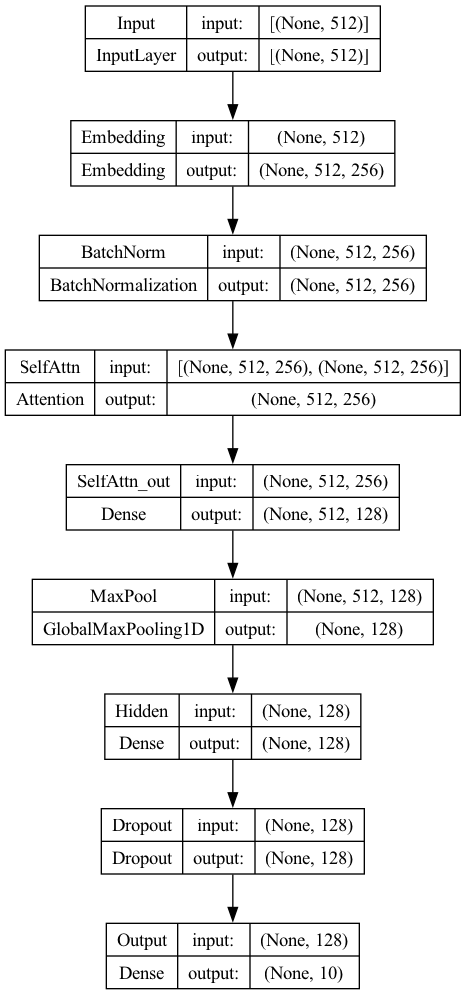

In [12]:
model = make_model()

## number of parameters
print(model.summary())

## plot model (save as model.png)
plot_model(model, show_shapes=True)

### fit model

In [13]:
## fit
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=128)

Epoch 1/10
86/86 [==============================] - 60s 695ms/step - loss: 1.3476 - accuracy: 0.5723 - val_loss: 2.3003 - val_accuracy: 0.1969
Epoch 2/10
86/86 [==============================] - 65s 753ms/step - loss: 0.7802 - accuracy: 0.7371 - val_loss: 2.2796 - val_accuracy: 0.3064
Epoch 3/10
86/86 [==============================] - 61s 709ms/step - loss: 0.5851 - accuracy: 0.7960 - val_loss: 1.8229 - val_accuracy: 0.6779
Epoch 4/10
86/86 [==============================] - 62s 721ms/step - loss: 0.4532 - accuracy: 0.8413 - val_loss: 1.1246 - val_accuracy: 0.7341
Epoch 5/10
86/86 [==============================] - 73s 844ms/step - loss: 0.3534 - accuracy: 0.8762 - val_loss: 0.8545 - val_accuracy: 0.7286
Epoch 6/10
86/86 [==============================] - 72s 840ms/step - loss: 0.2730 - accuracy: 0.9004 - val_loss: 0.7515 - val_accuracy: 0.7264
Epoch 7/10
86/86 [==============================] - 67s 783ms/step - loss: 0.2059 - accuracy: 0.9258 - val_loss: 0.8195 - val_accuracy: 0.7264

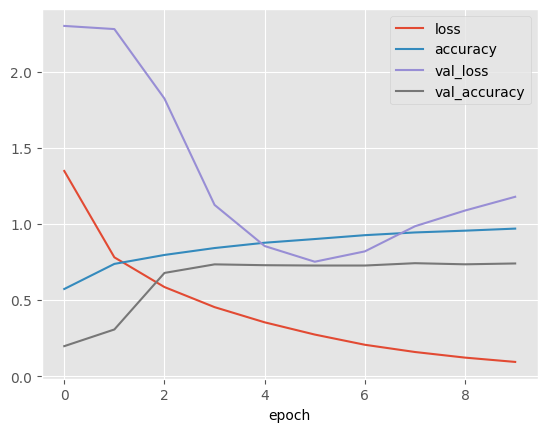

In [14]:
pd.DataFrame(history.history).plot(xlabel='epoch');

- validation loss increased = overfitting
- epoch 4-5 is enough

# Evaluate and re-train

107/107 [==============================] - 7s 61ms/step
               precision    recall  f1-score   support

        crime       0.69      0.53      0.60       428
      economy       0.81      0.69      0.75       250
    education       0.74      0.75      0.74       211
entertainment       0.92      0.83      0.87       185
      foreign       0.89      0.91      0.90       266
        local       0.41      0.38      0.40       388
     politics       0.85      0.87      0.86       627
    publicize       0.74      0.77      0.76       296
       region       0.58      0.75      0.65       531
        sport       0.95      0.87      0.91       240

     accuracy                           0.73      3422
    macro avg       0.76      0.74      0.74      3422
 weighted avg       0.73      0.73      0.73      3422



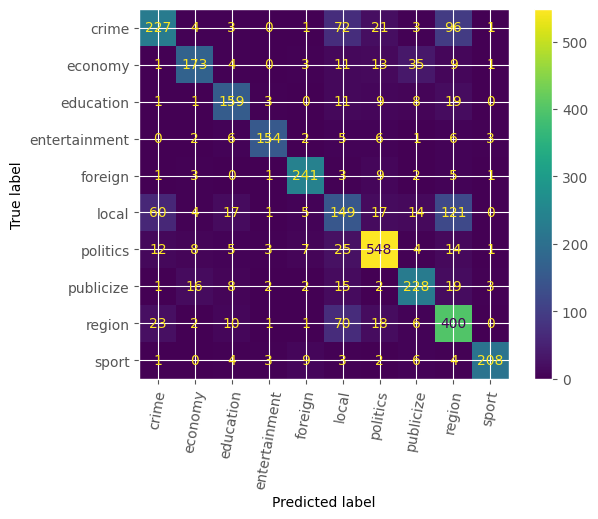

In [15]:
## predict
y_pred = y_encoder.inverse_transform(model.predict(X_test).argmax(axis=1))
y_true = y_encoder.inverse_transform(y_test.argmax(axis=1))

## print F1 scores
print(classification_report(y_true, y_pred))

## confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(xticks_rotation=80);

### re-train with epoch=5

Epoch 1/5
86/86 [==============================] - 69s 802ms/step - loss: 1.3220 - accuracy: 0.5737 - val_loss: 2.3021 - val_accuracy: 0.0913
Epoch 2/5
86/86 [==============================] - 69s 802ms/step - loss: 0.7608 - accuracy: 0.7437 - val_loss: 2.2836 - val_accuracy: 0.2440
Epoch 3/5
86/86 [==============================] - 69s 806ms/step - loss: 0.5803 - accuracy: 0.7966 - val_loss: 1.8006 - val_accuracy: 0.6651
Epoch 4/5
86/86 [==============================] - 74s 856ms/step - loss: 0.4547 - accuracy: 0.8406 - val_loss: 1.1334 - val_accuracy: 0.7169
Epoch 5/5
107/107 [==============================] - 7s 63ms/step
               precision    recall  f1-score   support

        crime       0.65      0.64      0.64       428
      economy       0.60      0.84      0.70       250
    education       0.76      0.68      0.72       211
entertainment       0.87      0.83      0.85       185
      foreign       0.95      0.83      0.89       266
        local       0.43      0.42 

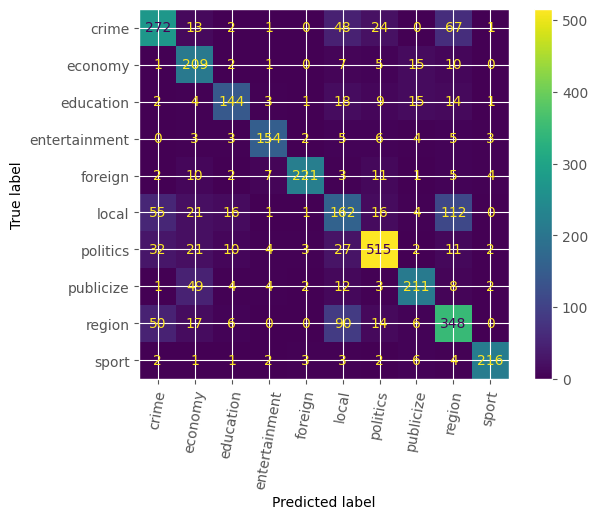

In [16]:
## compile model again
model2 = make_model()

## fit
history = model2.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=128)

## predict
y_pred = y_encoder.inverse_transform(model2.predict(X_test).argmax(axis=1))
y_true = y_encoder.inverse_transform(y_test.argmax(axis=1))

## print F1 scores
print(classification_report(y_true, y_pred))

## confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
disp.plot(xticks_rotation=80);